# Categorizing News Articles using ULMFit

We are using the AG News corpus for training a model to classify the news articles into 
1. World - Category 1
2. Sports - Category 2
3. Buisness - Category 3
4. Sci/Tech - Category 4

You can read about the AG News Corpus here http://xzh.me/docs/charconvnet.pdf

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.text import *
from fastai.callbacks import *

## Getting the data

In [14]:
path = f'data/'

downloading the data

In [27]:
!wget https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz -P {path}

extracting the data

In [28]:
!tar -zxf {path}/'ag_news_csv.tgz' -C {path}

## Preparing the data

In [15]:
path = Path('data/ag_news_csv')
path.ls()

[PosixPath('data/ag_news_csv/data_title_lm'),
 PosixPath('data/ag_news_csv/tmp_class'),
 PosixPath('data/ag_news_csv/tmp_desc_class'),
 PosixPath('data/ag_news_csv/train.csv'),
 PosixPath('data/ag_news_csv/test.csv'),
 PosixPath('data/ag_news_csv/.ipynb_checkpoints'),
 PosixPath('data/ag_news_csv/readme.txt'),
 PosixPath('data/ag_news_csv/data_lm'),
 PosixPath('data/ag_news_csv/models'),
 PosixPath('data/ag_news_csv/tmp_lm'),
 PosixPath('data/ag_news_csv/classes.txt'),
 PosixPath('data/ag_news_csv/data_desc_lm'),
 PosixPath('data/ag_news_csv/tmp_title_class')]

It only contains one csv file, let's have a look at it.

In [5]:
df_train = pd.read_csv(path/'train.csv',  names=["class", "title", "description"])
df_train.head()

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
df_test = pd.read_csv(path/'test.csv',  names=["class", "title", "description"])
df_test.head()

,class,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


taking the union of df_train and df_test

In [7]:
df = df_train.append(df_test, ignore_index=True)

In [8]:
len(df), len(df_train), len(df_test)

(127600, 120000, 7600)

In [9]:
df.head()

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Language Model with both Title and Description concatenated

In [13]:
data_lm = (TextList.from_df(df, path, cols=['title', 'description'])
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch())

In [15]:
data_lm.save('data_lm')

In [16]:
data_lm = load_data(path, 'data_lm')

In [17]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(114840, 12760)

In [13]:
data_lm.show_batch()

idx,text
0,"xxmaj group , \ which has a reputation for making well - timed and occasionally \ controversial plays in the defense industry , has quietly placed \ its bets on another part of the market . xxbos xxmaj oil and xxmaj economy xxmaj cloud xxmaj stocks ' xxmaj outlook ( xxmaj reuters ) xxmaj reuters - xxmaj soaring crude prices plus worries \ about the economy and the outlook for"
1,check in xxmaj july and ahead of weekly inventory data on xxmaj wednesday expected to show a decline in crude stocks . xxbos xxup hp 's order system chaos to continue throughout xxmaj august < strong > xxup hp xxmaj world < / strong > xxup sap hell lingers xxbos xxmaj feature : a xxmaj new xxup idea in xxmaj air xxmaj quality xxmaj monitoring xxmaj combining the assets of
2,"cnn / xxmaj money ) -- xxmaj internet search engine xxmaj google has announced it will go public at \ $ 85 a share , paving the way for the widely awaited but troubled stock offering to finally stumble to market on xxmaj thursday . xxbos xxmaj after the xxup ipo , xxmaj google may need to invest in itself xxup san xxup francisco xxmaj google 's star - crossed"
3,"agreed to limit flights into xxmaj chicago 's o ' xxmaj hare xxmaj international xxmaj airport at peak periods to stem record delays that have slowed aviation nationwide , federal officials said on xxmaj wednesday . xxbos xxup sec xxmaj rules xxmaj expand xxmaj disclosure xxmaj companies must disclose more information about their business deals and financial obligations starting xxmaj monday , when new xxmaj securities and xxmaj exchange xxmaj"
4,"savvy cost the xxmaj redmond , xxmaj wash. , behemoth millions of dollars , according to a company executive . xxbos xxup us xxmaj may xxmaj support xxmaj duplicate xxmaj gold for xxmaj korea in xxmaj olympic xxmaj gymnastics xxmaj the xxup us xxmaj olympic xxmaj committee said it may support a duplicate gold medal in the men 's all - around gymnastics event , as xxmaj south xxmaj korea"


In [14]:
data_lm.train_ds[100][0]

Text xxbos xxmaj prairie xxmaj dog xxmaj wo n't xxmaj be on xxmaj endangered xxmaj list ( xxup ap ) xxup ap - xxmaj the black - tailed prairie dog has been dropped from a list of candidates for the federal endangered species list because scientists have concluded the rodents are no longer threatened .

In [15]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

Now let's grab the full dataset for what follows.

In [16]:
data_lm.batch_size

64

We are using a pretrained model trained on wiki data. 

The pretrained model will be downloaded once you run the cell below (by specifying the arch=AWD_LSTM and pretrained=True, the fastai will take care of downloading the pretrained model). 

In [19]:
learn = language_model_learner(data_lm, arch=AWD_LSTM,  drop_mult=0)

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02


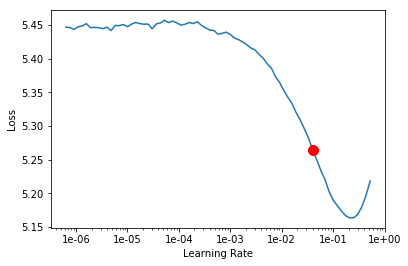

In [26]:
learn.recorder.plot(skip_end=15)

for saving the best model after every epoch, we have used SaveModelCallback

In [27]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-stage-1'))

Fit the model

In [28]:
learn.fit_one_cycle(3, 3.98E-02)

epoch,train_loss,valid_loss,accuracy
1,4.083878,4.062304,0.339157
2,3.717857,3.722002,0.369300
3,3.248870,3.456817,0.397454


Better model found at epoch 1 with val_loss value: 4.0623040199279785.
Better model found at epoch 2 with val_loss value: 3.722001791000366.
Better model found at epoch 3 with val_loss value: 3.456817150115967.


In [29]:
learn.load('lm-stage-1');

try fitting for few more epochs

In [30]:
learn.callback_fns.pop()
learn.callback_fns.append(partial(SaveModelCallback, name='lm-stage-2'))

In [31]:
learn.fit_one_cycle(7, 3.98E-02)

epoch,train_loss,valid_loss,accuracy
1,3.359498,3.607479,0.379275
2,3.925495,4.002438,0.343869
3,3.943836,3.979711,0.346884
4,3.755897,3.813142,0.361825
5,3.460189,3.591794,0.382240
6,3.136687,3.423983,0.401502
7,2.892702,3.397513,0.406059


Better model found at epoch 1 with val_loss value: 3.6074790954589844.
Better model found at epoch 5 with val_loss value: 3.5917937755584717.
Better model found at epoch 6 with val_loss value: 3.423983097076416.
Better model found at epoch 7 with val_loss value: 3.397512674331665.


In [20]:
learn.load('lm-stage-2');

Unfreeze and fine tune all the layers

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06


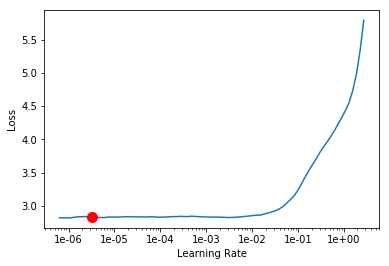

In [23]:
learn.recorder.plot()

In [24]:
# learn.callback_fns.pop()
learn.callback_fns.append(partial(SaveModelCallback, name='lm-unfreeze-1'))

In [25]:
learn.fit_one_cycle(5, 3e-04)

epoch,train_loss,valid_loss,accuracy
1,2.722163,3.323896,0.417000
2,2.650433,3.251339,0.427481
3,2.539935,3.232226,0.432916
4,2.447142,3.241854,0.434141
5,2.366892,3.255395,0.433954


Better model found at epoch 1 with val_loss value: 3.3238956928253174.
Better model found at epoch 2 with val_loss value: 3.2513391971588135.
Better model found at epoch 3 with val_loss value: 3.2322261333465576.


How good is our model? Well let's try to see what it predicts after a few given words.

In [26]:
learn.load('lm-unfreeze-1');

In [27]:
TEXT = "This year is going to challenge"
N_WORDS = 40
N_SENTENCES = 2

In [28]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This year is going to challenge Kazaa The Kazaa file - sharing software will be available for more than a month , according to a new Internet Protocol Application Services Corporation ( SBS ) . xxbos
This year is going to challenge Rooney 's old nemesis Wayne Rooney , who once ran the honour for Wayne Rooney . Not just looking at Wayne Rooney 's dilemma for their Old Trafford , but


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [29]:
learn.save_encoder('fine_tuned_enc')

## Text Classifier Model with Title and Description concatenated

In [12]:
df_train.columns, df_test.columns

(Index(['class', 'title', 'description'], dtype='object'),
 Index(['class', 'title', 'description'], dtype='object'))

Creating a data object for the text and its corresponding labels. Have concatenated the title and description into one field

Note: make sure you use same data_lm on which you have trained the language model

In [13]:
data_class = TextDataBunch.from_df(path, train_df = df_train, valid_df = df_test, vocab = data_lm.vocab, text_cols=['title','description'], label_cols="class", bs=64)

In [14]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [16]:
data_class.save('tmp_class')

In [18]:
data_class = load_data(path, 'tmp_class')

In [103]:
data_class.show_batch()

text,target
"xxbos xxmaj kyoto is xxmaj dead - xxmaj long xxmaj live xxmaj pragmatism xxmaj there 's troubling news ( xxup ft subscription xxunk , alternate copy here ) coming from xxmaj japan , where the xxmaj kyoto protocol on xxmaj greenhouse xxmaj emissions was born in 1997 . xxmaj it seems that the xxmaj japanese are n't going to be able to meet their emissions targets specified in the agreement",4
"xxbos xxmaj the tide is turning ... xxmaj whilst some may claim that the xxmaj british are staunch allies of the xxmaj united xxmaj states ( xxunk being having clearly different agendas on the xxmaj world xxmaj stage ) , the recent request made to xxmaj britain for additional support , namely 600 troops from xxmaj black xxmaj watch to be moved xxmaj north to xxmaj baghdad to help out",4
"xxbos peoplesoft awaits xxmaj delaware court ruling xxmaj the second and final week of a xxmaj delaware court trial relating to xxmaj oracle xxmaj corp. 's hostile takeover bid for peoplesoft xxmaj inc. turned into an extended negotiating session between the two sides . xxmaj oracle executives criticized peoplesoft 's business in an apparent attempt to drive down peoplesoft 's selling price , while peoplesoft rewrote for the sixth time",4
"xxbos xxmaj study : 100,000 civilian deaths due to xxmaj iraq invasion xxmaj today , the xxmaj lancet medical journal published a report which concludes that 100,000 civilians died in the xxup us - led invasion of xxmaj iraq . xxmaj this is an incredibly high estimate , and at first may seem too xxunk not to be propaganda . xxmaj but it can not easily be dismissed . xxmaj",4
"xxbos xxup mtv xxmaj awards xxmaj may xxmaj be xxmaj toned xxmaj down xxup new xxup york - xxmaj in the 21-year history of xxup mtv 's xxmaj video xxmaj music xxmaj awards , viewers have been treated to some eye - popping moments - xxmaj prince 's bare xxunk , xxmaj lil ' xxmaj kim 's xxunk xxunk , xxmaj britney and xxmaj madonna 's steamy kiss last year",1


In [105]:
data_class.classes

[1, 2, 3, 4]

In [106]:
data_class.batch_size

64

In [107]:
len(data_class.train_ds)

120000

In [108]:
data_class.train_ds[1][1]

Category 3

We now create a model to classify those reviews and load the encoder we saved before.

In [19]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


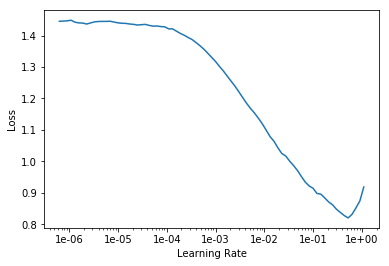

In [56]:
learn.recorder.plot()

In [57]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-stage-1'))

fitting the last layer

In [58]:
learn.fit_one_cycle(3, 2e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.328367,0.320080,0.887237,02:23
1,0.311090,0.254958,0.908158,02:25
2,0.256237,0.239733,0.914737,02:25


Better model found at epoch 0 with val_loss value: 0.320080429315567.
Better model found at epoch 1 with val_loss value: 0.2549576461315155.
Better model found at epoch 2 with val_loss value: 0.2397327721118927.


In [45]:
learn.load('class-stage-1');

freezing till the 3rd last layer

In [59]:
learn.freeze_to(-2)

In [63]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-stage-1')

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


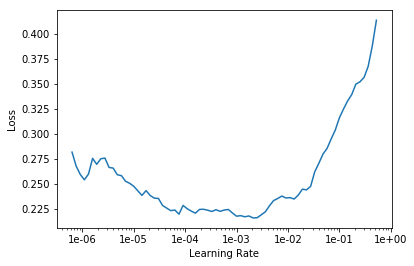

In [65]:
learn.recorder.plot()

In [66]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-stage-2'))

In [67]:
learn.fit_one_cycle(3, slice(1e-04/(2.6**4),1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.229637,0.238900,0.914210,02:56
1,0.233259,0.232494,0.918026,03:00
2,0.212088,0.230158,0.916842,02:59


Better model found at epoch 0 with val_loss value: 0.23890049755573273.
Better model found at epoch 1 with val_loss value: 0.2324937880039215.
Better model found at epoch 2 with val_loss value: 0.23015844821929932.


In [ ]:
learn.load('class-stage-2');

In [68]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-stage-2')]

In [69]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-stage-2')

In [70]:
learn.freeze_to(-3)

In [71]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


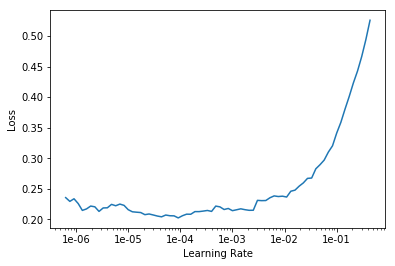

In [72]:
learn.recorder.plot()

In [73]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-stage-3'))

In [74]:
learn.fit_one_cycle(3, slice(9e-05/(2.6**4),9e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.200334,0.227150,0.918553,05:03
1,0.207154,0.219796,0.920921,05:06
2,0.185677,0.220501,0.921579,05:05


Better model found at epoch 0 with val_loss value: 0.22715014219284058.
Better model found at epoch 1 with val_loss value: 0.21979570388793945.


In [110]:
learn.load('class-stage-3');

In [111]:
learn.unfreeze()

In [76]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-stage-3')

In [78]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


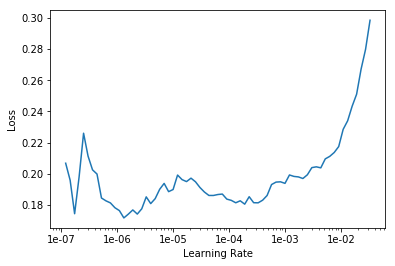

In [89]:
learn.recorder.plot(skip_start=1)

In [90]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-stage-4'))

In [91]:
learn.fit_one_cycle(5, slice(8e-07/(2.6**4), 8e-07))

epoch,train_loss,valid_loss,accuracy,time
0,0.208825,0.221303,0.922500,07:00
1,0.191689,0.220736,0.922632,07:01
2,0.204188,0.221225,0.922237,07:03
3,0.195844,0.222319,0.920921,07:02
4,0.200363,0.221953,0.920921,07:02


Better model found at epoch 0 with val_loss value: 0.2213030308485031.
Better model found at epoch 1 with val_loss value: 0.22073590755462646.


In [ ]:
learn.load('class-stage-3');
learn.unfreeze()

In [112]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


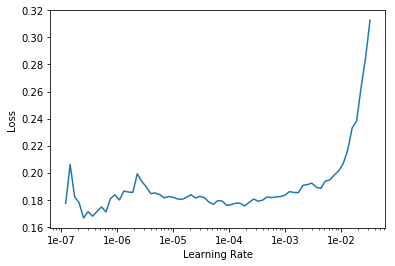

In [113]:
learn.recorder.plot(skip_start=1)

In [114]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-stage-5'))

In [115]:
learn.fit_one_cycle(5, slice(1e-04/(2.6**4), 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.199087,0.221900,0.919605,07:05
1,0.179001,0.215153,0.924211,07:07
2,0.176331,0.213342,0.925395,07:08
3,0.161703,0.213294,0.924342,07:07
4,0.139650,0.213541,0.924737,07:07


Better model found at epoch 0 with val_loss value: 0.22190043330192566.
Better model found at epoch 1 with val_loss value: 0.2151532918214798.
Better model found at epoch 2 with val_loss value: 0.21334177255630493.
Better model found at epoch 3 with val_loss value: 0.21329425275325775.


In [16]:
learn.predict("The British prime minister is with Brexit")

(Category 1,
 tensor(0),
 tensor([9.1608e-01, 4.1958e-05, 7.3538e-03, 7.6522e-02]))

In [17]:
learn.predict("The stock price has soared")

(Category 3, tensor(2), tensor([0.1319, 0.0007, 0.6888, 0.1785]))

In [96]:
learn.predict("A new organism has been found to increase the human lifespan")

(Category 4,
 tensor(3),
 tensor([2.3715e-04, 3.4884e-08, 7.0250e-05, 9.9969e-01]))

In [95]:
learn.predict("Shane watson scored a century in cricket.")

(Category 1, tensor(0), tensor([0.5614, 0.2516, 0.0019, 0.1851]))

## Confusion Matrix - Title & Description Field

In [20]:
learn.load('class-stage-5');

In [21]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

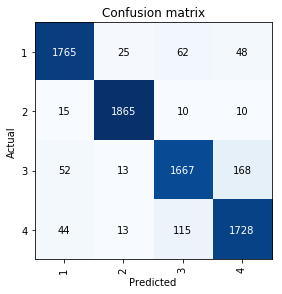

In [22]:
interp.plot_confusion_matrix()

## Language Model with only Description Field

In [30]:
data_desc_lm = (TextList.from_df(df, path, cols=['description'])
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch())

In [31]:
data_desc_lm.save('data_desc_lm')

In [6]:
data_desc_lm = load_data(path, 'data_desc_lm')

In [11]:
len(data_desc_lm.train_ds), len(data_desc_lm.valid_ds)

(114840, 12760)

In [12]:
data_desc_lm.show_batch()

idx,text
0,the market . xxbos xxmaj reuters - xxmaj soaring crude prices plus worries \ about the economy and the outlook for earnings are expected to \ hang over the stock market next week during the depth of the \ summer doldrums . xxbos xxmaj reuters - xxmaj authorities have halted oil export \ flows from the main pipeline in southern xxmaj iraq after \ intelligence showed a rebel militia
1,"xxmaj corp. ( xxup cost.o ) , \ claiming the company kept women out of top store management \ posts . xxbos xxup new xxup york ( xxmaj reuters ) - xxup u.s. stocks ended higher on xxmaj tuesday , even as oil prices hit another record , as investors were encouraged by data showing an easing of inflationary pressure and a sharp rebound in the housing market ."
2,"xxmaj union head office said xxmaj tuesday it had concerns over xxmaj italian budget deficit figures , only a week after xxmaj greece was challenged over alleged sloppy bookkeeping and possible underreporting of deficit figures . xxbos xxmaj virgin boss xxmaj sir xxmaj richard xxmaj branson says the firm is in talks with a xxmaj chinese company over starting a mobile phone service in mainland xxmaj china . xxbos"
3,"airlines , xxmaj american and xxmaj united , announced on xxmaj wednesday that they would cut flights at o ' xxmaj hare xxmaj international xxmaj airport to ease congestion that has been delaying flights from coast to coast . xxbos xxup us xxmaj airways faces a serious risk of going out of business , according to some leading airline analysts , despite claims by the xxup ceo of the"
4,"xxmaj crushed by her failure to finish in the women 's marathon on xxmaj sunday , a shell - shocked xxmaj paula xxmaj radcliffe broke down twice again xxmaj monday as she struggled to explain how her dreams were shattered . xxbos a former xxup us army sergeant who deserted to xxmaj north xxmaj korea in the 1960s has arrived on a remote xxmaj japanese island to start what"


In [13]:
data_desc_lm.batch_size

64

In [22]:
learn = language_model_learner(data_desc_lm, arch=AWD_LSTM,  drop_mult=0)

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


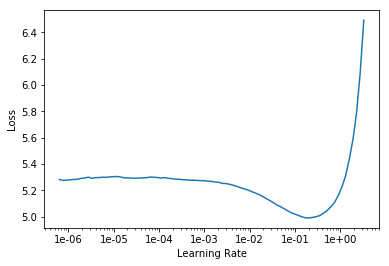

In [38]:
learn.recorder.plot()

In [45]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-desc-stage-1'))

In [46]:
learn.fit_one_cycle(3, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.901958,3.887195,0.338864,06:06
1,3.544283,3.554093,0.372143,06:10
2,3.073897,3.309334,0.399991,06:11


Better model found at epoch 0 with val_loss value: 3.887195110321045.
Better model found at epoch 1 with val_loss value: 3.554093360900879.
Better model found at epoch 2 with val_loss value: 3.3093338012695312.


In [47]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='lm-desc-stage-1')

In [48]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-desc-stage-2'))

In [49]:
learn.fit_one_cycle(3, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.718091,3.822854,0.347566,06:10
1,3.477342,3.542294,0.373964,06:11
2,3.008730,3.316930,0.401139,06:11


Better model found at epoch 0 with val_loss value: 3.8228535652160645.
Better model found at epoch 1 with val_loss value: 3.5422940254211426.
Better model found at epoch 2 with val_loss value: 3.316929578781128.


In [15]:
# learn.callback_fns.pop()
learn.callback_fns.append(partial(SaveModelCallback, name='lm-desc-stage-3'))

In [16]:
learn.load('lm-desc-stage-2');

In [17]:
learn.fit_one_cycle(7, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.125074,3.447565,0.383943,06:07
1,3.685704,3.803422,0.348296,06:10
2,3.726231,3.789276,0.350870,06:10
3,3.544124,3.635617,0.365562,06:10
4,3.237897,3.430451,0.386405,06:10
5,2.911173,3.284670,0.405991,06:10
6,2.689448,3.263679,0.410048,06:10


Better model found at epoch 0 with val_loss value: 3.4475653171539307.
Better model found at epoch 4 with val_loss value: 3.4304511547088623.
Better model found at epoch 5 with val_loss value: 3.284669876098633.
Better model found at epoch 6 with val_loss value: 3.263678789138794.


In [23]:
learn.load('lm-desc-stage-3');

In [24]:
learn.unfreeze()

In [19]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='lm-desc-stage-3')

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


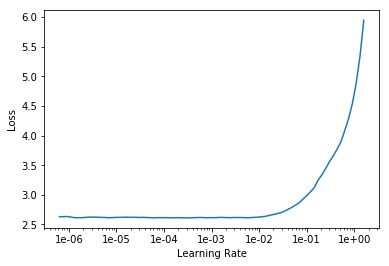

In [26]:
learn.recorder.plot()

In [27]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-desc-unfreeze-stage-1'))

In [28]:
learn.fit_one_cycle(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.585051,3.187106,0.421673,07:20
1,2.700900,3.146081,0.425302,07:20
2,2.697094,3.106902,0.430661,07:21
3,2.552260,3.062537,0.439291,07:21
4,2.339710,3.048209,0.448196,07:21
5,2.065824,3.058329,0.457909,07:21
6,1.728793,3.124197,0.463582,07:21
7,1.382863,3.257582,0.466604,07:22
8,1.081178,3.411885,0.465452,07:22
9,0.911664,3.515364,0.462368,07:22


Better model found at epoch 0 with val_loss value: 3.187105894088745.
Better model found at epoch 1 with val_loss value: 3.14608097076416.
Better model found at epoch 2 with val_loss value: 3.1069023609161377.
Better model found at epoch 3 with val_loss value: 3.062537431716919.
Better model found at epoch 4 with val_loss value: 3.0482089519500732.


In [31]:
learn.callback_fns.pop()

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True),
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='lm-desc-unfreeze-stage-1')]

In [32]:
learn.load('lm-desc-unfreeze-stage-1');

In [33]:
TEXT = "This year is going to challenge"
N_WORDS = 40
N_SENTENCES = 2

In [34]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This year is going to challenge Virgin Atlantic Airways ' Vijay Singh with the launch of the Virgin Open Links on Tuesday . There are no one - tenth of the company 's xxbos AP
This year is going to challenge Apple Computer for the Mac OS . The software is the latest version of Apple 's online music player . xxbos The New England Patriots ' offense has been sporting


In [35]:
learn.save_encoder('lm-desc-encoder-1');

## Text Classifier Model with only description field

In [37]:
data_desc_class = TextDataBunch.from_df(path, train_df = df_train, valid_df = df_test, vocab = data_desc_lm.vocab, text_cols=['description'], label_cols="class", bs=64)

In [38]:
data_desc_class.save('tmp_desc_class')

In [23]:
data_desc_class = load_data(path, 'tmp_desc_class')

In [10]:
data_desc_class.show_batch()

text,target
"xxbos xxmaj there 's troubling news ( xxup ft subscription xxunk , alternate copy here ) coming from xxmaj japan , where the xxmaj kyoto protocol on xxmaj greenhouse xxmaj emissions was born in 1997 . xxmaj it seems that the xxmaj japanese are n't going to be able to meet their emissions targets specified in the agreement in time . xxmaj indeed , unless they buy a "" large",4
"xxbos xxmaj navy vs. xxmaj vanderbilt < br > xxmaj records : xxmaj midshipmen 3 - 0 ; xxmaj commodores 0 - 2 . < br > xxmaj when : 1:30 p.m. xxmaj where : xxmaj navy - xxmaj marine xxmaj corps xxmaj memorial xxmaj stadium . xxmaj radio : xxup xxunk ( in progress ) , xxup xxunk . < br > xxmaj off and xxmaj running : xxmaj",2
"xxbos \ \ xxmaj john xxmaj xxunk blogs about xxmaj rojo : \ "" xxmaj yesterday i hung out with xxmaj chris xxmaj alden , a founder of the original xxmaj red xxmaj herring \ who has moved his focus to publishing in a xxmaj web 2.0 world ( in other words , a \ fellow traveler ) . xxmaj he 's putting the finishing touches on a new publishing",4
xxbos \ \ xxmaj it turns out that the only prediction i made in 2004 is n't going to come true . \ \ i bet that xxmaj dell would ship a version of xxmaj linux . i doubt they will now . \ xxmaj honestly they seemed like the leading candidate considering their entry into the \ xxup mp3 market at the time . \ \ i still think,4
"xxbos \ \ i 've been a big fan of xxunk for a while now but have n't migrated any code \ over for one central reason . xxmaj the following line of code : \ \ final static xxmaj logger logger = logger.getlogger ( "" xxunk "" ) ; \ \ ... is amazingly ugly and difficult to work with . \ \ xxmaj most people use xxunk with",4


In [24]:
learn = text_classifier_learner(data_desc_class, AWD_LSTM, drop_mult=0.)
learn.load_encoder('lm-desc-encoder-1')
learn.freeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


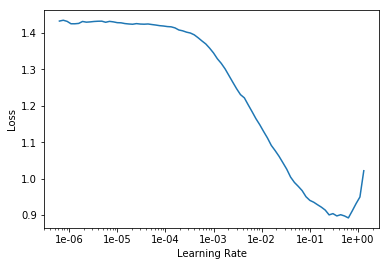

In [43]:
learn.recorder.plot()

In [44]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-stage-1'))

In [45]:
learn.fit_one_cycle(3, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.384903,0.335307,0.882368,01:58
1,0.303527,0.286344,0.898553,02:00
2,0.277487,0.267152,0.906316,02:01


Better model found at epoch 0 with val_loss value: 0.33530664443969727.
Better model found at epoch 1 with val_loss value: 0.2863442003726959.
Better model found at epoch 2 with val_loss value: 0.2671515643596649.


In [51]:
learn.load('class-desc-stage-1');

In [52]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-stage-2'))

In [53]:
learn.fit_one_cycle(3, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.319757,0.309955,0.895395,02:00
1,0.318523,0.286681,0.900395,02:01
2,0.265240,0.259957,0.907105,02:01


Better model found at epoch 0 with val_loss value: 0.3099547326564789.
Better model found at epoch 1 with val_loss value: 0.2866806387901306.
Better model found at epoch 2 with val_loss value: 0.2599571645259857.


In [54]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-stage-2')

In [55]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-stage-3'))

In [56]:
learn.fit_one_cycle(5, 4e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.315579,0.295192,0.891447,01:58
1,0.329155,0.307388,0.899605,02:00
2,0.297397,0.290245,0.895789,02:00
3,0.269863,0.263068,0.906842,02:01
4,0.239246,0.255417,0.909605,02:01


Better model found at epoch 0 with val_loss value: 0.29519227147102356.
Better model found at epoch 2 with val_loss value: 0.2902452349662781.
Better model found at epoch 3 with val_loss value: 0.2630678117275238.
Better model found at epoch 4 with val_loss value: 0.25541651248931885.


In [57]:
learn.load('class-desc-stage-3');

In [58]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-stage-3')

In [59]:
learn.freeze_to(-2)

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


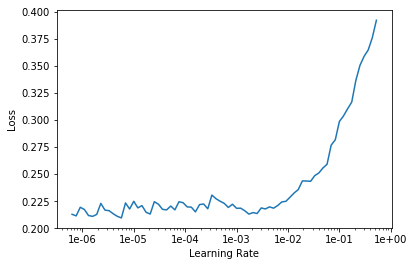

In [61]:
learn.recorder.plot()

In [62]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-2stage-3'))

In [63]:
learn.fit_one_cycle(5, slice(1e-04/(2.6**4),1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.225620,0.254007,0.908947,02:26
1,0.221833,0.251945,0.910395,02:29
2,0.223906,0.248906,0.911053,02:30
3,0.210349,0.249121,0.910789,02:30
4,0.198432,0.249376,0.909868,02:29


Better model found at epoch 0 with val_loss value: 0.2540072500705719.
Better model found at epoch 1 with val_loss value: 0.25194478034973145.
Better model found at epoch 2 with val_loss value: 0.24890568852424622.


In [64]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-unfreeze-2stage-3')

In [65]:
learn.load('class-desc-unfreeze-2stage-3');

In [66]:
learn.freeze_to(-3)

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


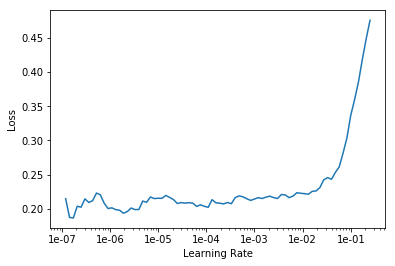

In [70]:
learn.recorder.plot(skip_start=1)

In [69]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-3stage-3'))

In [71]:
learn.fit_one_cycle(5, slice(1e-05/(2.6**4),1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.223578,0.249505,0.911842,04:14
1,0.224286,0.249800,0.910789,04:17
2,0.212604,0.248891,0.911447,04:17
3,0.197748,0.249724,0.913553,04:16
4,0.218704,0.248675,0.912237,04:15


Better model found at epoch 0 with val_loss value: 0.24950483441352844.
Better model found at epoch 2 with val_loss value: 0.24889059364795685.
Better model found at epoch 4 with val_loss value: 0.2486753761768341.


In [76]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-unfreeze-4stage-3')

In [77]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-4stage-3'))

In [75]:
learn.load('class-desc-unfreeze-3stage-3');

In [78]:
learn.fit_one_cycle(5, slice(1e-05/(2.6**4),1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.208001,0.248347,0.912895,04:13
1,0.195496,0.247859,0.911711,04:16
2,0.208054,0.247311,0.911974,04:17
3,0.210866,0.248618,0.912368,04:16
4,0.206960,0.247410,0.913816,04:16


Better model found at epoch 0 with val_loss value: 0.2483471930027008.
Better model found at epoch 1 with val_loss value: 0.2478586882352829.
Better model found at epoch 2 with val_loss value: 0.24731102585792542.


In [79]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-unfreeze-4stage-3')

In [80]:
learn.load('class-desc-unfreeze-4stage-3');

In [81]:
learn.unfreeze()

In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


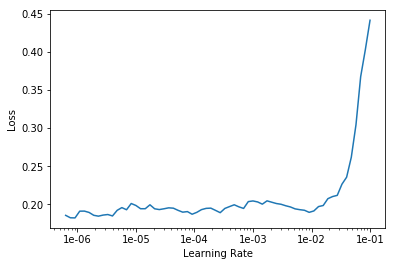

In [83]:
learn.recorder.plot()

In [84]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-full-stage-1'))

In [85]:
learn.fit_one_cycle(5, slice(1e-05/(2.6**4),1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.208282,0.248668,0.911579,05:51
1,0.215628,0.246903,0.911579,05:52
2,0.205564,0.245341,0.912500,05:54
3,0.194276,0.246093,0.912368,05:54
4,0.181914,0.246400,0.913684,05:54


Better model found at epoch 0 with val_loss value: 0.24866849184036255.
Better model found at epoch 1 with val_loss value: 0.24690334498882294.
Better model found at epoch 2 with val_loss value: 0.2453405112028122.


In [86]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-unfreeze-full-stage-1')

In [88]:
learn.load('class-desc-unfreeze-full-stage-1');

In [89]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-full-stage-2'))

In [90]:
learn.fit_one_cycle(5, slice(1e-02/(2.6**4),1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.252891,0.246341,0.912763,05:52
1,0.183075,0.221748,0.926316,05:54
2,0.089094,0.243985,0.927237,05:54
3,0.040155,0.292246,0.928684,05:54
4,0.007536,0.369227,0.932763,05:54


Better model found at epoch 0 with val_loss value: 0.2463410198688507.
Better model found at epoch 1 with val_loss value: 0.22174754738807678.


In [91]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-desc-unfreeze-full-stage-2')

In [92]:
learn.load('class-desc-unfreeze-full-stage-1');

In [93]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-desc-unfreeze-full-stage-3'))

In [94]:
learn.fit_one_cycle(5, slice(1e-03/(2.6**4),1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.203061,0.241846,0.915263,05:54
1,0.170986,0.235299,0.924342,05:53
2,0.093053,0.266895,0.922632,05:53
3,0.049265,0.311164,0.921711,05:54
4,0.032447,0.323559,0.920658,05:53


Better model found at epoch 0 with val_loss value: 0.24184578657150269.
Better model found at epoch 1 with val_loss value: 0.23529905080795288.


In [97]:
learn.load('class-desc-unfreeze-full-stage-2');

In [98]:
learn.predict("The British prime minister is with Brexit")

(Category 1, tensor(0), tensor([0.7671, 0.0130, 0.0753, 0.1447]))

In [99]:
learn.predict("The stock price has soared")

(Category 3, tensor(2), tensor([0.0072, 0.0161, 0.9658, 0.0109]))

In [100]:
learn.predict("A new organism has been found to increase the human lifespan")

(Category 4, tensor(3), tensor([0.1255, 0.0021, 0.0173, 0.8551]))

In [101]:
learn.predict("Shane watson scored a century in cricket.")

(Category 1, tensor(0), tensor([0.8682, 0.1176, 0.0011, 0.0130]))

## Confusion Matrix - Description Field

In [25]:
learn.load('class-desc-unfreeze-full-stage-2');

In [26]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

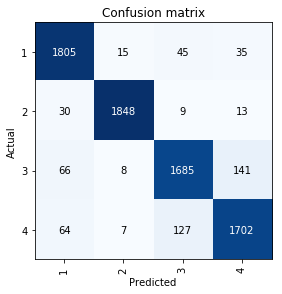

In [27]:
interp.plot_confusion_matrix()

## Language model with title

In [120]:
data_title_lm = (TextList.from_df(df, path, cols='title')
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch())

In [121]:
data_title_lm.save('data_title_lm')

In [122]:
data_title_lm = load_data(path, 'data_title_lm')

In [123]:
len(data_title_lm.train_ds), len(data_title_lm.valid_ds)

(114840, 12760)

In [124]:
data_title_lm.show_batch()

idx,text
0,"reuters ) xxbos xxmaj oil prices soar to all - time record , posing new menace to xxup us economy ( xxup afp ) xxbos xxmaj stocks xxmaj end xxmaj up , xxmaj but xxmaj near xxmaj year xxmaj lows ( xxmaj reuters ) xxbos xxmaj money xxmaj funds xxmaj fell in xxmaj latest xxmaj week ( xxup ap ) xxbos xxmaj fed minutes show dissent over inflation ("
1,"blockade ' xxbos xxup j.c. xxmaj penney xxmaj posts xxmaj profit , xxmaj sales xxmaj strong xxbos xxmaj treasuries , xxmaj oil xxmaj up , xxmaj inflation in xxmaj check xxbos xxmaj windows xxup xp xxmaj security xxmaj update xxmaj delayed ( xxup ap ) xxbos xxmaj network xxmaj solutions is xxmaj xxunk xxbos xxmaj eagles xxmaj defensive xxmaj end xxmaj kalu xxmaj out for xxmaj year ( xxup"
2,"alters xxmaj holiday xxmaj after xxmaj xxunk xxmaj bombs , xxmaj xxunk xxmaj says xxbos xxup un xxmaj marks xxmaj anniversary of xxmaj bombing of xxmaj baghdad xxmaj mission xxbos xxmaj oil xxmaj hits xxmaj new xxmaj record as xxmaj demand xxmaj soars xxbos xxmaj toshiba , xxmaj memory - xxmaj tech xxmaj develop xxmaj new xxup dvd ( xxup ap ) xxbos xxmaj before - the - xxmaj"
3,prove words count xxbos xxmaj xxunk xxmaj xxunk xxmaj and xxmaj xxunk xxmaj one xxmaj win xxmaj away xxmaj from xxmaj olympic xxmaj medals xxbos xxmaj kidnappers lift death threat on xxup us journalist xxbos xxmaj german police detain 74 neo - xxmaj nazis xxbos xxmaj absent xxmaj phelps xxmaj gets xxmaj eighth xxmaj medal xxbos xxmaj basketball : xxmaj lithuania xxmaj shoots xxmaj down xxmaj united xxmaj states
4,xxmaj pentium 4 prices xxbos xxunk loses in finals as xxup us women 's wrestlers settle for two < b > ... < / b > xxbos xxmaj may / xxmaj walsh advance to gold - medal match xxbos xxmaj kadyrov 's xxmaj birthday xxmaj xxunk xxbos xxmaj deepest xxmaj image of xxmaj exploded xxmaj star xxmaj uncovers xxmaj xxunk xxmaj jets xxbos xxmaj kraft xxmaj foods xxmaj orders


In [137]:
learn = language_model_learner(data_title_lm, arch=AWD_LSTM,  drop_mult=0)

In [138]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


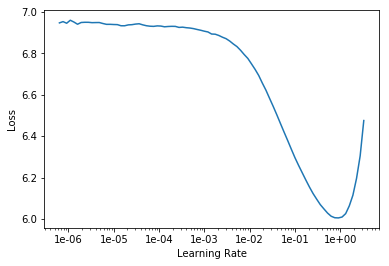

In [139]:
learn.recorder.plot()

In [140]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-title-stage-1'))

In [141]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,4.129588,4.137038,0.391144,01:21
1,4.357418,4.302376,0.386360,01:21
2,4.134869,4.105156,0.398317,01:21
3,3.752205,3.870212,0.415697,01:21
4,3.355767,3.810336,0.422346,01:21


Better model found at epoch 0 with val_loss value: 4.137038230895996.
Better model found at epoch 2 with val_loss value: 4.105155944824219.
Better model found at epoch 3 with val_loss value: 3.8702120780944824.
Better model found at epoch 4 with val_loss value: 3.810335636138916.


In [142]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='lm-title-stage-1')

In [143]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-title-stage-2'))

In [144]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,3.711385,4.068010,0.398860,01:20
1,4.190280,4.232347,0.388809,01:21
2,4.009610,4.063832,0.400929,01:21
3,3.663325,3.852069,0.418153,01:22
4,3.276495,3.807362,0.423480,01:21


Better model found at epoch 0 with val_loss value: 4.068010330200195.
Better model found at epoch 2 with val_loss value: 4.0638322830200195.
Better model found at epoch 3 with val_loss value: 3.85206937789917.
Better model found at epoch 4 with val_loss value: 3.8073623180389404.


In [148]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='lm-title-stage-3')

In [149]:
learn.load('lm-title-stage-2');

In [150]:
learn.unfreeze()

In [151]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


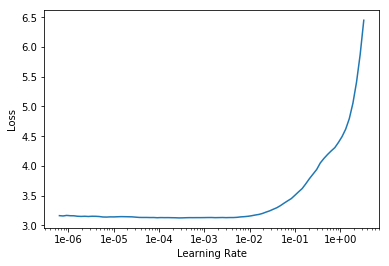

In [153]:
learn.recorder.plot()

In [154]:
learn.callback_fns.append(partial(SaveModelCallback, name='lm-title-unfreeze-1'))

In [155]:
learn.fit_one_cycle(5,4e-03)

epoch,train_loss,valid_loss,accuracy,time
0,3.178271,3.770115,0.428246,01:41
1,3.191603,3.644045,0.438055,01:42
2,2.879646,3.617557,0.449946,01:42
3,2.399651,3.723859,0.457957,01:42
4,1.958857,3.973649,0.455134,01:42


Better model found at epoch 0 with val_loss value: 3.7701148986816406.
Better model found at epoch 1 with val_loss value: 3.644045114517212.
Better model found at epoch 2 with val_loss value: 3.617556571960449.


In [160]:
learn.save_encoder('lm-title-encoder')

## Text Classifier Model with only Title Field

In [156]:
data_title_class = TextDataBunch.from_df(path, train_df = df_train, valid_df = df_test, vocab = data_title_lm.vocab, text_cols='title', label_cols="class", bs=64)

In [157]:
data_title_class.save('tmp_title_class')

In [28]:
data_title_class = load_data(path, 'tmp_title_class')

In [159]:
data_title_class.show_batch()

text,target
"xxbos xxmaj not xxmaj all xxmaj jobs xxmaj belong xxmaj to xxmaj the xxmaj white xxmaj man : xxmaj asian xxmaj minorities , xxmaj xxunk xxmaj action , xxmaj and xxmaj the xxmaj quest xxmaj for xxmaj parity xxmaj at xxmaj",3
xxbos xxmaj strong c \ $ cuts xxmaj aber xxmaj diamond xxup q3 net to xxup us \ $ 8.5 m ; dividend and < b > ... < / b,3
"xxbos xxmaj dell xxmaj drops 15 xxup gb xxmaj dell xxup dj xxmaj to xxup us \ $ 149 , 20 xxup gb for xxup us \ $",4
xxbos xxmaj roy xxmaj halladay back in form to lead xxmaj blue xxmaj jays in 4 - 2 victory over < b > ... < / b,2
xxbos xxup td xxmaj bank to buy xxmaj new xxmaj england retail bank xxmaj banknorth for \ $ 3.8 billion < b > ... < / b,3


In [29]:
learn = text_classifier_learner(data_title_class, AWD_LSTM, drop_mult=0.)
learn.load_encoder('lm-title-encoder')
learn.freeze()

In [163]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


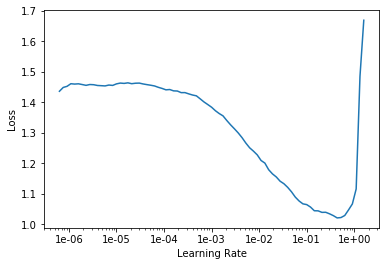

In [164]:
learn.recorder.plot()

In [165]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-title-stage-1'))

In [166]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.635907,0.606560,0.776579,00:43
1,0.662830,3.010307,0.730132,00:43
2,0.622813,1.146041,0.767895,00:43
3,0.610216,0.583851,0.788289,00:44
4,0.560091,0.581433,0.797895,00:44


Better model found at epoch 0 with val_loss value: 0.606559693813324.
Better model found at epoch 3 with val_loss value: 0.5838505625724792.
Better model found at epoch 4 with val_loss value: 0.5814326405525208.


In [167]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-title-stage-1')

In [168]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-title-stage-2'))

In [169]:
learn.fit_one_cycle(5, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,0.656013,0.647975,0.765395,00:44
1,0.664047,0.635589,0.778816,00:44
2,0.623990,0.605002,0.781579,00:43
3,0.582444,0.588918,0.785132,00:43
4,0.541050,0.619946,0.798421,00:44


Better model found at epoch 0 with val_loss value: 0.6479746699333191.
Better model found at epoch 1 with val_loss value: 0.6355886459350586.
Better model found at epoch 2 with val_loss value: 0.6050015687942505.
Better model found at epoch 3 with val_loss value: 0.5889179706573486.


In [170]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-title-stage-2')

In [171]:
learn.freeze_to(-2)

In [172]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


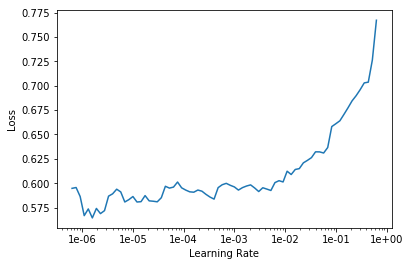

In [173]:
learn.recorder.plot()

In [174]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-title-unfreeze-2-stage-1'))

In [175]:
learn.fit(7, slice(2e-06/(2.6**4),2e-06))

epoch,train_loss,valid_loss,accuracy,time
0,0.567804,0.589189,0.786842,00:52
1,0.568958,0.586493,0.786711,00:53
2,0.579276,0.586887,0.788289,00:53
3,0.592869,0.780831,0.788816,00:52
4,0.568225,0.599208,0.790263,00:52
5,0.560702,0.583827,0.792237,00:53
6,0.557737,0.887980,0.789605,00:53


Better model found at epoch 0 with val_loss value: 0.5891892313957214.
Better model found at epoch 1 with val_loss value: 0.5864930748939514.
Better model found at epoch 5 with val_loss value: 0.5838268995285034.


In [176]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-title-unfreeze-2-stage-1')

In [177]:
learn.load('class-title-unfreeze-2-stage-1');

In [178]:
learn.freeze_to(-3)

In [179]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


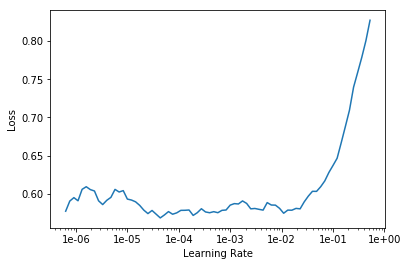

In [180]:
learn.recorder.plot()

In [181]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-title-unfreeze-3-stage-1'))

In [182]:
learn.fit_one_cycle(5, slice(1e-03/(2.6**4),1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.525849,0.497869,0.823421,01:31
1,0.403280,0.500089,0.845921,01:32
2,0.315427,0.442300,0.854605,01:33
3,0.194417,0.487398,0.853947,01:32
4,0.147243,0.509602,0.852368,01:32


Better model found at epoch 0 with val_loss value: 0.49786853790283203.
Better model found at epoch 2 with val_loss value: 0.44230034947395325.


In [183]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='class-title-unfreeze-3-stage-1')

In [185]:
learn.load('class-title-unfreeze-3-stage-1');

In [186]:
learn.unfreeze()

In [187]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


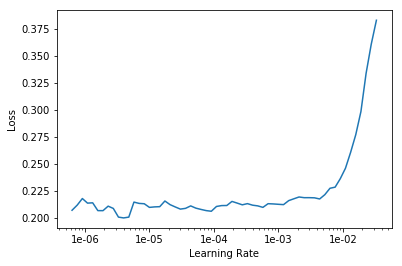

In [188]:
learn.recorder.plot()

In [189]:
learn.callback_fns.append(partial(SaveModelCallback, name='class-title-unfreeze-full-stage-1'))

In [190]:
learn.fit_one_cycle(5, slice(1e-04/(2.6**4),1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.182758,0.443832,0.855132,02:10
1,0.174409,0.474735,0.854474,02:11
2,0.176960,0.503990,0.853684,02:11
3,0.142911,0.499949,0.853026,02:11
4,0.145581,0.505959,0.852237,02:11


Better model found at epoch 0 with val_loss value: 0.4438323974609375.


## Confusion Matrix

In [30]:
learn.load('class-title-unfreeze-full-stage-1');

In [31]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

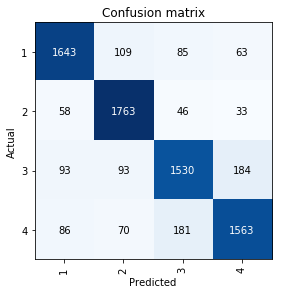

In [32]:
interp.plot_confusion_matrix()

## Findings

We trained models with three below variants of data
1. Title and Description
2. Only Description
3. Title

The accuracy for points 1 and 2 are the same. 

The accuracy for p3 is the lowest as the title of news are mostly cryptic in nature and determining the category from the same is difficult.